In [1]:
from pathlib import Path
import os
import pandas as pd
import sys
import requests
import torch
import torchvision
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch 
from einops import rearrange, repeat
from loguru import logger
from torchmetrics import Metric, BootStrapper
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from matplotlib.pyplot import figure
from cka import gram, centering_mat, centered_gram, unbiased_hsic_xy, MinibatchCKA, HookedCache, make_pairwise_metrics, update_metrics, get_simmat_from_metrics
import numpy as np
import pickle
from get_models import get_model


os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import timm
from torch.utils.tensorboard import SummaryWriter

sys.path.append('../')
import models_mae

writer = SummaryWriter()

DEVICE = torch.device('cpu')
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')

/private/home/sshkhr/.conda/envs/pytorch_env/lib/python3.9/site-packages/MinkowskiEngine-0.5.4-py3.9-linux-x86_64.egg/MinkowskiEngine/__init__.py:36: UserWarning: The environment variable `OMP_NUM_THREADS` not set. MinkowskiEngine will automatically set `OMP_NUM_THREADS=16`. If you want to set `OMP_NUM_THREADS` manually, please export it on the command line before running a python script. e.g. `export OMP_NUM_THREADS=12; python your_program.py`. It is recommended to set it below 24.
  warnings.warn(


In [2]:
from torch.nn.modules.container import Sequential
from timm.models.vision_transformer import Block

In [3]:
# using the validation transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize,
        ])

## Randomly subsample features too

data_path='/datasets01/imagenet_full_size/061417/'
dataset = torchvision.datasets.ImageFolder(data_path + 'val', transform=transform)

In [4]:
indexes = np.random.uniform(low=0, high=len(dataset), size=1024).astype(int)
subset = torch.utils.data.Subset(dataset, indexes)

data_loader = torch.utils.data.DataLoader(subset,
                                        batch_size=32,
                                        shuffle=False,
                                        pin_memory=False)

log_every = 10
do_log = True

# ViT vs ConvNext

In [5]:
vit_mae_model = get_model('MAE', 'pretrained')
convnext_model = get_model('ConvNext', 'pretrained')
convnext_model.to(DEVICE)
convnext_model.eval()
vit_mae_model.to(DEVICE)
vit_mae_model.eval()

Weights of ConvNeXtV2 not initialized from pretrained model: ['norm.weight', 'norm.bias', 'head.weight', 'head.bias']
loaded ConvNext


MaskedAutoencoderViT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate=none)
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
      (ls2): Identity()
      (drop_path2): Identity()

In [6]:
#%%time

log_every = 1

modt_hooks = []
for name, module in vit_mae_model.named_modules():
  if 'drop' not in name and 'ls' not in name and 'out_proj' not in name and 'decoder' not in name and 'block' in name and 'head' not in name and name != 'blocks' and not isinstance(module, Sequential) and not isinstance(module, Block):
    print(name, type(module))
    tgt = name
    hook = HookedCache(vit_mae_model, tgt)
    modt_hooks.append(hook)

modc_hooks = []
for name, module in convnext_model.named_modules():
  if 'drop' not in name and name != 'downsample_layers' and name != 'stages' and name != 'norm' and name != 'head':
    print(name, type(module))
    tgt = name
    hook = HookedCache(convnext_model, tgt)
    modc_hooks.append(hook)

blocks.0.norm1 <class 'torch.nn.modules.normalization.LayerNorm'>
blocks.0.attn <class 'timm.models.vision_transformer.Attention'>
blocks.0.attn.qkv <class 'torch.nn.modules.linear.Linear'>
blocks.0.attn.proj <class 'torch.nn.modules.linear.Linear'>
blocks.0.norm2 <class 'torch.nn.modules.normalization.LayerNorm'>
blocks.0.mlp <class 'timm.models.layers.mlp.Mlp'>
blocks.0.mlp.fc1 <class 'torch.nn.modules.linear.Linear'>
blocks.0.mlp.act <class 'torch.nn.modules.activation.GELU'>
blocks.0.mlp.fc2 <class 'torch.nn.modules.linear.Linear'>
blocks.1.norm1 <class 'torch.nn.modules.normalization.LayerNorm'>
blocks.1.attn <class 'timm.models.vision_transformer.Attention'>
blocks.1.attn.qkv <class 'torch.nn.modules.linear.Linear'>
blocks.1.attn.proj <class 'torch.nn.modules.linear.Linear'>
blocks.1.norm2 <class 'torch.nn.modules.normalization.LayerNorm'>
blocks.1.mlp <class 'timm.models.layers.mlp.Mlp'>
blocks.1.mlp.fc1 <class 'torch.nn.modules.linear.Linear'>
blocks.1.mlp.act <class 'torch.nn.

In [12]:
metrics_ct = make_pairwise_metrics(modc_hooks, modt_hooks, device=DEVICE)
metrics_cc = make_pairwise_metrics(modc_hooks, modc_hooks, device=DEVICE)
metrics_tt = make_pairwise_metrics(modt_hooks, modt_hooks, device=DEVICE)

with torch.no_grad():
  
  for it, [batch, label] in enumerate(data_loader):
    batch = batch.to(DEVICE)
    do_log =  (it % log_every == 0)
    if do_log:
      logger.debug(f"iter: {it}")
    outv_c = convnext_model(batch)
    outv_t = vit_mae_model(batch)

    update_metrics(modc_hooks, modt_hooks, metrics_ct, "cka/ct", do_log,  device=DEVICE)
    update_metrics(modc_hooks, modc_hooks, metrics_cc, "cka/cc", do_log,  device=DEVICE)
    update_metrics(modt_hooks, modt_hooks, metrics_tt, "cka/tt", do_log,  device=DEVICE)
        
    for hook0 in modc_hooks:
      for hook1 in modt_hooks:
        hook0.clear()
        hook1.clear()

2023-01-12 11:56:39.663 | DEBUG    | __main__:<cell line: 5>:11 - iter: 0


KeyboardInterrupt: 

In [ ]:
sim_mat_cc = get_simmat_from_metrics(metrics_cc)
sim_mat_ct = get_simmat_from_metrics(metrics_ct)
sim_mat_tt = get_simmat_from_metrics(metrics_tt)

In [ ]:
with open('sim_mat_convnext-mae.pkl', 'wb') as f:
    pickle.dump(sim_mat_cc, f)

with open('sim_mat_convnext_vit-mae.pkl', 'wb') as f:
    pickle.dump(sim_mat_ct, f)

with open('sim_mat_vit-mae.pkl', 'wb') as f:
    pickle.dump(sim_mat_tt, f)

In [ ]:
with open('sim_mat_vit-mae.pkl', 'rb') as f:
    sim_mat_tt = pickle.load(f)

with open('sim_mat_convnext_vit-mae.pkl', 'rb') as f:
    sim_mat_ct = pickle.load(f)

with open('sim_mat_convnext-mae.pkl', 'rb') as f:
    sim_mat_cc = pickle.load(f)

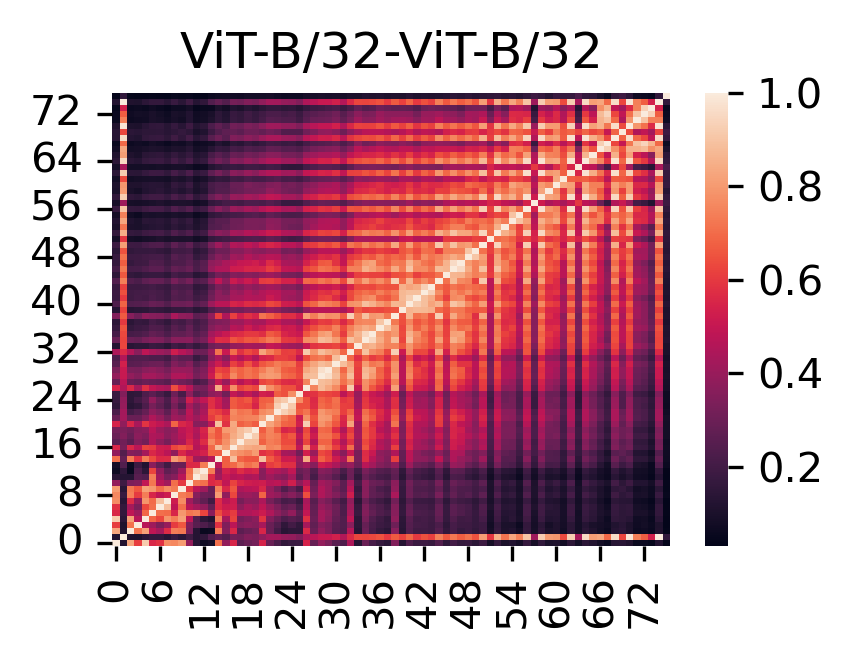

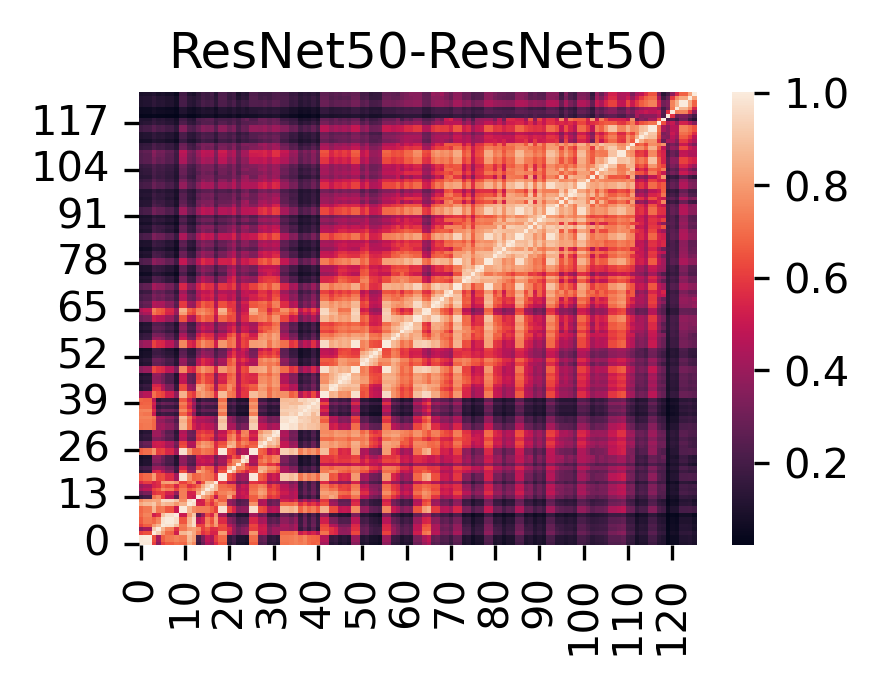

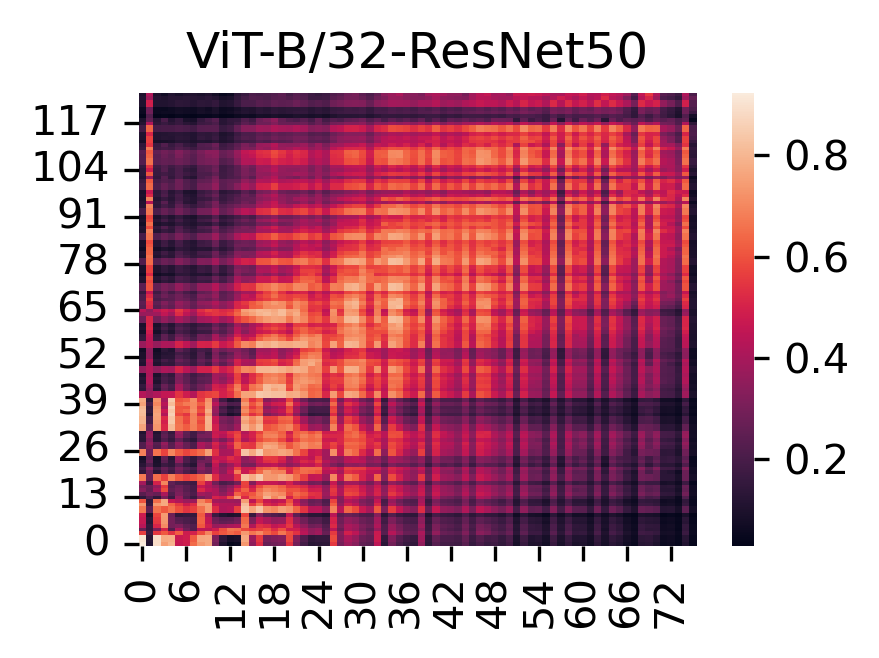

In [ ]:
figure(figsize=(3, 2), dpi=300)

ax = sns.heatmap(sim_mat_tt)
ax.invert_yaxis()
plt.title('ViT-B/32-ViT-B/32')
plt.show()

figure(figsize=(3, 2), dpi=300)

ax = sns.heatmap(sim_mat_cc)
ax.invert_yaxis()
plt.title('ResNet50-ResNet50')
plt.show()

figure(figsize=(3, 2), dpi=300)

ax = sns.heatmap(sim_mat_ct)
ax.invert_yaxis()
plt.title('ViT-B/32-ResNet50')
plt.show()